<a href="https://colab.research.google.com/github/hungf181/ThucTap_FaceEmotion/blob/main/facial_emotion_recognition_with_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install scikit-plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
warnings.simplefilter("ignore")
from keras.models import Model
from keras.layers import LeakyReLU
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.layers.merge import concatenate
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NCKH-LH/fer2013.csv')
data.shape

(35887, 3)

In [ ]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
data = data.sample(frac=1)

In [ ]:
labels = to_categorical(data[['emotion']], num_classes=7)
print(labels)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [ ]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [ ]:
pixels = train_pixels.reshape((35887*2304,1))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [ ]:
pixels = train_pixels.reshape((35887, 48, 48,1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


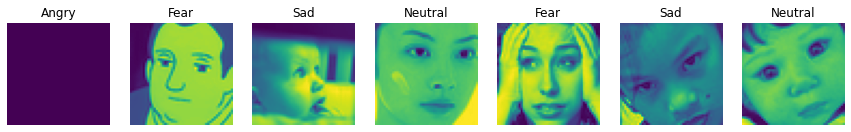

In [ ]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [ ]:
datagen.fit(X_train)
valgen.fit(X_val)

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

## CNN model

In [ ]:
def cnn_model():

  net = Sequential()

  net.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=(48, 48, 1), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
  net.add(BatchNormalization(name='batchnorm_1'))
  net.add(Conv2D( filters=64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_2' ))
  net.add(BatchNormalization(name='batchnorm_2'))

  net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
  net.add(Dropout(0.4, name='dropout_1'))
  net.add(Conv2D( filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_3' ))
  net.add(BatchNormalization(name='batchnorm_3'))
  net.add(Conv2D( filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_4' ))
  net.add(BatchNormalization(name='batchnorm_4'))

  net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
  net.add(Dropout(0.4, name='dropout_2'))
  net.add(Conv2D( filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_5' ))
  net.add(BatchNormalization(name='batchnorm_5'))
  net.add(Conv2D( filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_6'))
  net.add(BatchNormalization(name='batchnorm_6'))

  net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
  net.add(Dropout(0.5, name='dropout_3'))

  net.add(Flatten(name='flatten'))
    
  net.add(Dense( 128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
  net.add(BatchNormalization(name='batchnorm_7'))
  net.add(Dropout(0.6, name='dropout_4'))
  net.add(Dense( 7, activation='softmax', name='out_layer'))
  
  return net

In [ ]:
model = cnn_model()

In [ ]:
model.compile(
    optimizer = Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)       

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")

callbacks = [
    early_stopping,
    lr_scheduler
]

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    batch_size=32,   
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_generator)

Epoch 1/100
455/455 [==============================] - 34s 42ms/step - loss: 2.0848 - accuracy: 0.2615 - val_loss: 1.6820 - val_accuracy: 0.3402 - lr: 0.0010
Epoch 2/100
455/455 [==============================] - 19s 43ms/step - loss: 1.6460 - accuracy: 0.3599 - val_loss: 1.5434 - val_accuracy: 0.4108 - lr: 0.0010
Epoch 3/100
455/455 [==============================] - 18s 40ms/step - loss: 1.4688 - accuracy: 0.4292 - val_loss: 1.5086 - val_accuracy: 0.4523 - lr: 0.0010
Epoch 4/100
455/455 [==============================] - 18s 40ms/step - loss: 1.3856 - accuracy: 0.4689 - val_loss: 1.3162 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 5/100
455/455 [==============================] - 18s 40ms/step - loss: 1.3244 - accuracy: 0.4958 - val_loss: 1.2927 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 6/100
455/455 [==============================] - 20s 44ms/step - loss: 1.2850 - accuracy: 0.5110 - val_loss: 1.3860 - val_accuracy: 0.4885 - lr: 0.0010
Epoch 7/100
455/455 [==============================]

In [ ]:
model.save('cnn_model_07.h5')

In [ ]:
model = tf.keras.models.load_model('cnn_model_30epoch_Adam.h5')

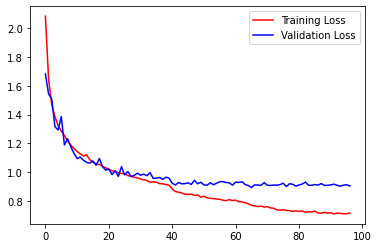

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

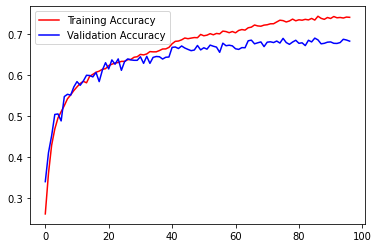

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [ ]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 10ms/step - loss: 0.9044 - accuracy: 0.7005
Test Acc: 0.7004736661911011


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

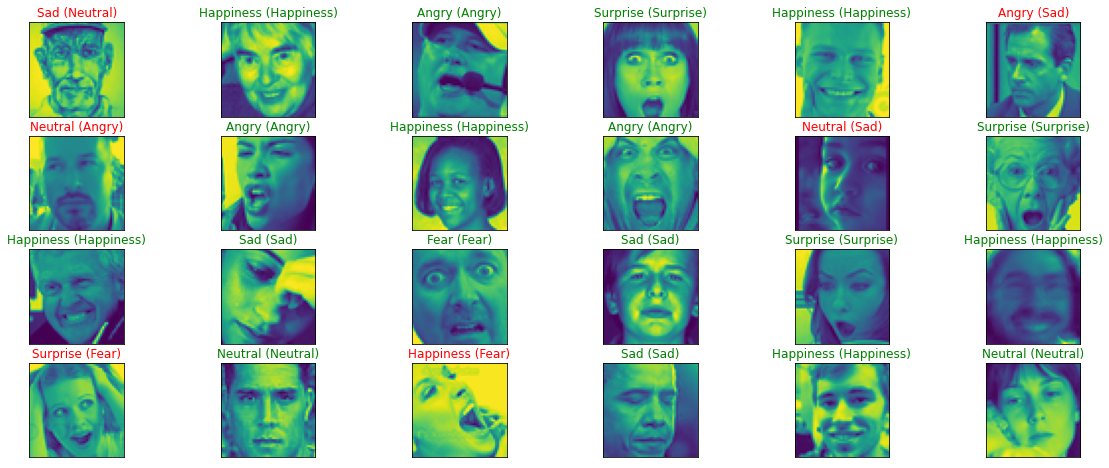

In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

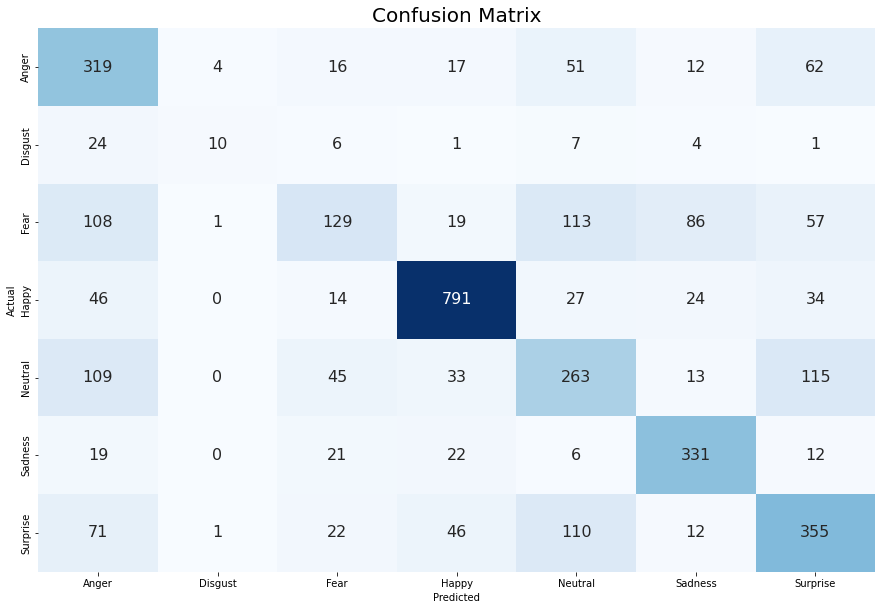

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.458     0.663     0.542       481
           1      0.625     0.189     0.290        53
           2      0.510     0.251     0.337       513
           3      0.851     0.845     0.848       936
           4      0.456     0.455     0.455       578
           5      0.687     0.805     0.741       411
           6      0.558     0.575     0.567       617

    accuracy                          0.612      3589
   macro avg      0.592     0.541     0.540      3589
weighted avg      0.614     0.612     0.602      3589



# Fine tuning


## Changing optimizer

Changing Optimizer to Stochastic Gradient Descent (SGD)

In [ ]:
model = cnn_model()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - 16s 33ms/step - loss: 14.8196 - accuracy: 0.1539 - val_loss: 14.0593 - val_accuracy: 0.1985

Epoch 00001: val_accuracy did not improve from 0.59567
Epoch 2/30
455/455 [==============================] - 15s 34ms/step - loss: 14.3687 - accuracy: 0.1768 - val_loss: 13.7992 - val_accuracy: 0.2111

Epoch 00002: val_accuracy did not improve from 0.59567
Epoch 3/30
455/455 [==============================] - 16s 34ms/step - loss: 14.0486 - accuracy: 0.1875 - val_loss: 13.5927 - val_accuracy: 0.2424

Epoch 00003: val_accuracy did not improve from 0.59567
Epoch 4/30
455/455 [==============================] - 15s 33ms/step - loss: 13.7566 - accuracy: 0.1952 - val_loss: 13.3435 - val_accuracy: 0.2458

Epoch 00004: val_accuracy did not improve from 0.59567
Epoch 5/30
455/455 [==============================] - 16s 34ms/step - loss: 13.5038 - accuracy: 0.1994 - val_loss: 13.1095 - val_accuracy: 0.2576

Epoch 00005: val_accuracy did not improve fro

In [ ]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 6ms/step - loss: 12.0536 - accuracy: 0.2940
Test Acc: 0.2939537465572357


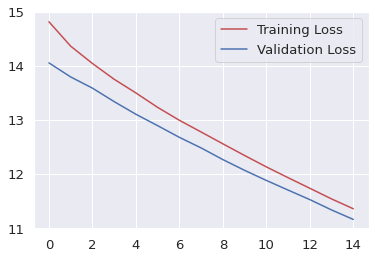

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

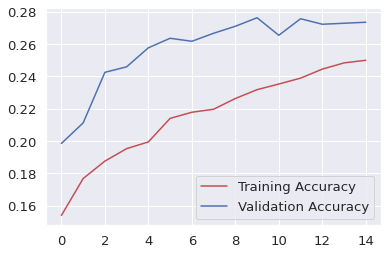

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

The model trained with SGD did not give better results than Adam optimizer.

## Changing epoch number

Let's change the epoch number as 50 for the cnn_model.

In [ ]:
model = cnn_model()

In [ ]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
455/455 [==============================] - 17s 35ms/step - loss: 14.0537 - accuracy: 0.1861 - val_loss: 12.7927 - val_accuracy: 0.2467

Epoch 00001: val_accuracy improved from -inf to 0.24675, saving model to best_model.h5
Epoch 2/50
455/455 [==============================] - 15s 33ms/step - loss: 12.1575 - accuracy: 0.2115 - val_loss: 10.9201 - val_accuracy: 0.2542

Epoch 00002: val_accuracy improved from 0.24675 to 0.25418, saving model to best_model.h5
Epoch 3/50
455/455 [==============================] - 16s 35ms/step - loss: 10.1796 - accuracy: 0.2310 - val_loss: 9.0228 - val_accuracy: 0.2780

Epoch 00003: val_accuracy improved from 0.25418 to 0.27802, saving model to best_model.h5
Epoch 4/50
455/455 [==============================] - 15s 34ms/step - loss: 8.3048 - accuracy: 0.2444 - val_loss: 7.2841 - val_accuracy: 0.2709

Epoch 00004: val_accuracy did not improve from 0.27802
Epoch 5/50
455/455 [==============================] - 16s 34ms/step - loss: 6.6573 - accuracy

In [ ]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 6ms/step - loss: 1.4005 - accuracy: 0.6442
Test Acc: 0.6441906094551086


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

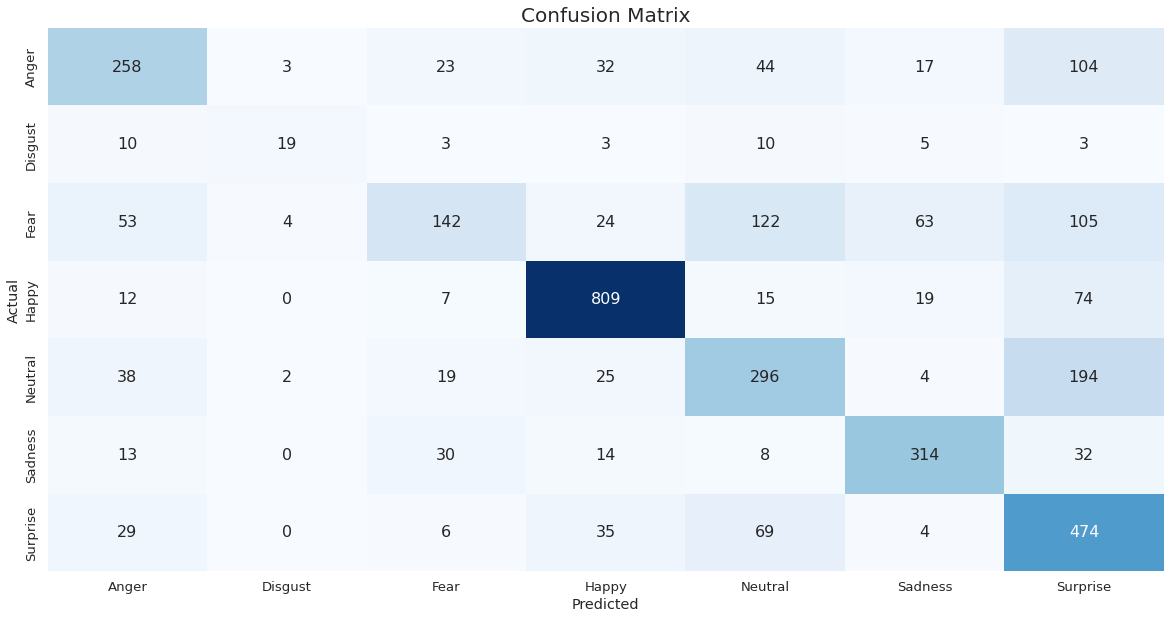

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.625     0.536     0.577       481
           1      0.679     0.358     0.469        53
           2      0.617     0.277     0.382       513
           3      0.859     0.864     0.862       936
           4      0.525     0.512     0.518       578
           5      0.737     0.764     0.750       411
           6      0.481     0.768     0.591       617

    accuracy                          0.644      3589
   macro avg      0.646     0.583     0.593      3589
weighted avg      0.658     0.644     0.635      3589



In [ ]:
model.save('epoch50.h5')

The model trained with 50 epochs has better results than the model trained with 30 epochs.